# **Analysis of results**

## **Libraries**

In [1]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## **Directories**

In [2]:
DATA_FOLDER = 'data'

CHECKPOINT_100_LOG_FILE = os.path.join(DATA_FOLDER, 'dev_checkpoint_100.log')

## **Log format**

### **Log parsing**

In [3]:
log_lines = []
with open(CHECKPOINT_100_LOG_FILE, 'r') as f:
    log_lines = f.readlines()

In [4]:
log_lines[-60:-50]

['[2023-05-19 18:47:12] [valid] Ep. 41 : Up. 11628 : cross-entropy : 174.214 : stalled 4 times (last best: 150.118)\n',
 '[2023-05-19 18:48:43] [valid] Ep. 41 : Up. 11628 : translation : 0 : stalled 4 times (last best: 0)\n',
 '[2023-05-19 18:59:40] [valid] References contain unknown word, metric scores may be inaccurate\n',
 "[2023-05-19 18:59:40] [valid] First sentence's tokens as scored:\n",
 '[2023-05-19 18:59:40] [valid] DefaultVocab keeps original segments for scoring\n',
 '[2023-05-19 18:59:40] [valid]   Hyp: El presidente Mario Abdo BenÃ\xadtez firmÃ³ un comunicado en el que adjunta un comunicado en el cual los alumnos fueron entregados por ABC Cardinal y a las 8:00 en la que atraviesa la avenida Mariscal LÃ³pez y para la avenida Mariscal LÃ³pez.\n',
 '[2023-05-19 18:59:40] [valid]   Ref: El escÃ¡ndalo causado en TaiwÃ¡n por el hoy exjefe <unk> la DirecciÃ³n Nacional <unk> Migraciones JuliÃ¡n Vega, que avergÃ¼enza a los paraguayos, revela que su nombramiento no respondiÃ³ preci

The format of log files is: 

```[DATE] [valid] Ep. <METRIC_0> : <VALUE_0> ... <METRIC_n> : <VALUE_n> : (stalled n times|new best)\n```

In [5]:
log_regex = r'''
    \[(\d{4})-(\d{2})-(\d{2})\s(\d{2}):(\d{2}):(\d{2})\]\s
    \[valid\]\s
    Ep\.\s(\S+)\s:\s
    Up\.\s(\S+)\s
    (?::\s(\S+)\s:\s(\S+))+\s
    :\s(.+)
'''
log_regex = re.compile(log_regex, re.VERBOSE)

In [6]:
def parse_line_groups(lines, regex):
    # type: (list[str], re.Pattern) -> list[tuple[str, str, str, str, str, str]]
    line_groups = []

    for line in lines:
        match = regex.match(line)
        if match:
            line_groups.append(match.groups()) 

    return line_groups   

In [7]:
lines = parse_line_groups(log_lines, log_regex)
[' '.join(lines for lines in line_group) for line_group in lines[30:35]]

['2023 05 19 19 32 55 69 20000 cross-entropy 209.237 stalled 7 times (last best: 150.118)',
 '2023 05 19 19 34 21 69 20000 translation 0 stalled 7 times (last best: 0)',
 '2023 05 19 19 37 09 71 20350 bleu 1.00836 stalled 3 times (last best: 1.01402)',
 '2023 05 19 19 38 44 71 20350 chrf 18.7132 new best',
 '2023 05 19 19 38 53 71 20350 cross-entropy 210.21 stalled 8 times (last best: 150.118)']

### **Convert log to dataframe**

In [8]:
def create_log_dataframe(parsed_lines, debug=False):
    # type: (list[tuple[str, str, str, str, str, str]], bool) -> pd.DataFrame
    log_by_epoch = dict()
    seen_epochs = set()
    static_columns = ['index', 'epoch', 'year', 'month', 'day', 'hour', 'minute', 'second', 'update', 'status']
    for column in static_columns:
        log_by_epoch[column] = []

    for idx, line in enumerate(parsed_lines):
        year, month, day,\
        hour, minute, second,\
        epoch, update,\
        metric, metric_value,\
        status = line

        static_values_to_append = [idx, epoch, year, month, day, hour, minute, second, update, status]

        if epoch not in seen_epochs:
            seen_epochs.add(epoch)
            for column, value in zip(static_columns, static_values_to_append):
                log_by_epoch[column].append(value)

        if metric not in log_by_epoch:
            log_by_epoch[metric] = []
        log_by_epoch[metric].append(metric_value)

    if debug:
        print('seen epochs: {}'.format(seen_epochs))
    
    return pd.DataFrame(log_by_epoch)

In [9]:
log_dataframe = create_log_dataframe(lines)

In [10]:
log_dataframe

,index,epoch,year,month,day,hour,minute,second,update,status,bleu,chrf,cross-entropy,translation
0,0,11,2023,05,19,17,54,09,2906,new best,0.664301,13.8332,150.118,0
1,4,21,2023,05,19,18,10,10,5814,new best,0.993281,16.3294,154.281,0
2,8,31,2023,05,19,18,25,22,8722,stalled 1 times (last best: 0.993281),0.94615,17.0948,163.313,0
3,12,35,2023,05,19,18,35,33,10000,stalled 2 times (last best: 0.993281),0.934937,16.646,168.286,0
4,16,41,2023,05,19,18,45,35,11628,new best,1.00003,17.7762,174.214,0
5,20,51,2023,05,19,19,01,10,14534,new best,1.01402,18.1807,185.707,0
6,24,61,2023,05,19,19,16,49,17442,stalled 1 times (last best: 1.01402),1.01227,18.0586,198.333,0
7,28,69,2023,05,19,19,31,16,20000,stalled 2 times (last best: 1.01402),0.986412,18.2387,209.237,0
8,32,71,2023,05,19,19,37,09,20350,stalled 3 times (last best: 1.01402),1.00836,18.7132,210.21,0
9,36,81,2023,05,19,19,52,35,23256,stalled 4 times (last best: 1.01402),1.00012,18.4778,221.907,0


In [11]:
log_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          12 non-null     int64 
 1   epoch          12 non-null     object
 2   year           12 non-null     object
 3   month          12 non-null     object
 4   day            12 non-null     object
 5   hour           12 non-null     object
 6   minute         12 non-null     object
 7   second         12 non-null     object
 8   update         12 non-null     object
 9   status         12 non-null     object
 10  bleu           12 non-null     object
 11  chrf           12 non-null     object
 12  cross-entropy  12 non-null     object
 13  translation    12 non-null     object
dtypes: int64(1), object(13)
memory usage: 1.4+ KB


<font color='orange'>*Obs:* All the columns have object Dtype</font>

In [12]:
categorical_columns = ['status']
numerical_columns = [col for col in log_dataframe.columns if col not in categorical_columns]
log_dataframe[numerical_columns] = log_dataframe[numerical_columns].astype(float)

In [13]:
log_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          12 non-null     float64
 1   epoch          12 non-null     float64
 2   year           12 non-null     float64
 3   month          12 non-null     float64
 4   day            12 non-null     float64
 5   hour           12 non-null     float64
 6   minute         12 non-null     float64
 7   second         12 non-null     float64
 8   update         12 non-null     float64
 9   status         12 non-null     object 
 10  bleu           12 non-null     float64
 11  chrf           12 non-null     float64
 12  cross-entropy  12 non-null     float64
 13  translation    12 non-null     float64
dtypes: float64(13), object(1)
memory usage: 1.4+ KB


## **Log analysis**

### **Metrics**

In [14]:
def plot_metrics_by_epoch(dataframe, metrics, save_path=None):
    num_metrics = len(metrics)
    
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(ncols=num_metrics, figsize=(4*num_metrics, 4))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(x='epoch', y=metric, data=dataframe, ax=ax)
        ax.set_title(metric)

        highest_value = dataframe[metric].max()
        max_index = dataframe[dataframe[metric] == highest_value]['epoch'].values[0]
        ax.plot(max_index, highest_value, marker='o', markersize=8, color='red')
        ax.text(max_index, highest_value - highest_value/20, f'{highest_value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(save_path) if save_path is not None else plt.show()

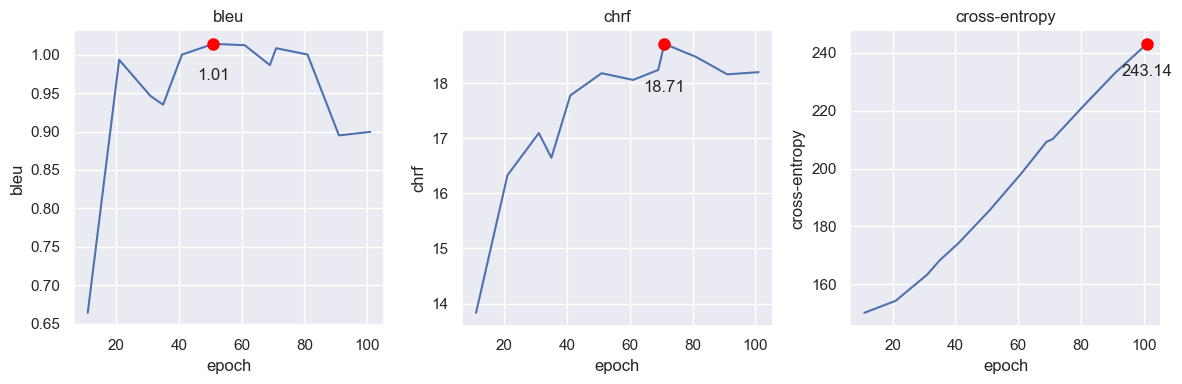

In [15]:
metrics = ['bleu', 'chrf', 'cross-entropy']
plot_metrics_by_epoch(log_dataframe, metrics)

In [16]:
log_dataframe.describe()

,index,epoch,year,month,day,hour,minute,second,update,bleu,chrf,cross-entropy,translation
count,12.000000,12.000000,12.0,12.0,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,22.000000,55.333333,2023.0,5.0,19.0,18.666667,28.083333,21.166667,15824.166667,0.946206,17.475725,192.663250,0.0
std,14.422205,28.371988,0.0,0.0,0.0,0.887625,17.349133,14.288160,8251.452774,0.098560,1.363591,31.319167,0.0
min,0.000000,11.000000,2023.0,5.0,19.0,17.000000,1.000000,2.000000,2906.000000,0.664301,13.833200,150.118000,0.0
25%,11.000000,34.000000,2023.0,5.0,19.0,18.000000,14.500000,9.750000,9680.500000,0.926102,16.982600,167.042750,0.0
50%,22.000000,56.000000,2023.0,5.0,19.0,19.000000,28.000000,19.000000,15988.000000,0.989846,18.109350,192.020000,0.0
75%,33.000000,73.500000,2023.0,5.0,19.0,19.000000,39.000000,33.500000,21076.500000,1.002180,18.209675,213.134250,0.0
max,44.000000,101.000000,2023.0,5.0,19.0,20.000000,54.000000,49.000000,29073.000000,1.014020,18.713200,243.137000,0.0


### **Time**

In [17]:
def add_time_diff(dataframe):
    # type: (pd.DataFrame) -> pd.DataFrame
    dataframe['datetime'] = pd.to_datetime(dataframe[['year', 'month', 'day', 'hour', 'minute', 'second']])
    dataframe['time_diff'] = dataframe['datetime'].diff()
    return dataframe

In [18]:
log_dataframe = add_time_diff(log_dataframe)

In [19]:
log_dataframe['time_diff']

0                NaT
1    0 days 00:16:01
2    0 days 00:15:12
3    0 days 00:10:11
4    0 days 00:10:02
5    0 days 00:15:35
6    0 days 00:15:39
7    0 days 00:14:27
8    0 days 00:05:53
9    0 days 00:15:26
10   0 days 00:15:27
11   0 days 00:15:22
Name: time_diff, dtype: timedelta64[ns]

In [20]:
log_dataframe['time_diff'].describe()

count                           11
mean     0 days 00:13:34.090909090
std      0 days 00:03:19.984726689
min                0 days 00:05:53
25%                0 days 00:12:19
50%                0 days 00:15:22
75%                0 days 00:15:31
max                0 days 00:16:01
Name: time_diff, dtype: object

In [21]:
def plot_time_diff(dataframe, index, value, save_path=None):
    sns.set(style='darkgrid')
    sns.barplot(x=index, y=value, data=dataframe, palette='Blues_d')

    for index, row in dataframe.iterrows():
        text_value = str(row['time_diff']).split(' ')[-1]
        text_value = text_value.split(':')[1:]
        text_value = ':'.join(text_value)
        plt.text(index, row['time_diff_sec'], text_value, ha='center', va='bottom')

    mean = dataframe['time_diff_sec'].mean()
    std = dataframe['time_diff_sec'].std()
    plt.axhline(mean, color='#FF8C00', linestyle='--', label='Mean')
    #plt.axhspan(mean - std, mean + std, facecolor='orange', alpha=0.3, label='Deviation')
    mean_text = '{}:{}'.format(int(mean) // 60, int(mean % 60))
    plt.text(0, mean, mean_text, ha='center', va='bottom')

    plt.xlabel('Index')
    plt.ylabel('Time Difference (seconds)')
    plt.title('Time Differences between Consecutive Tuples')
    plt.savefig(save_path) if save_path is not None else plt.show()

In [22]:
log_dataframe['time_diff_sec'] = log_dataframe['time_diff'].dt.total_seconds()

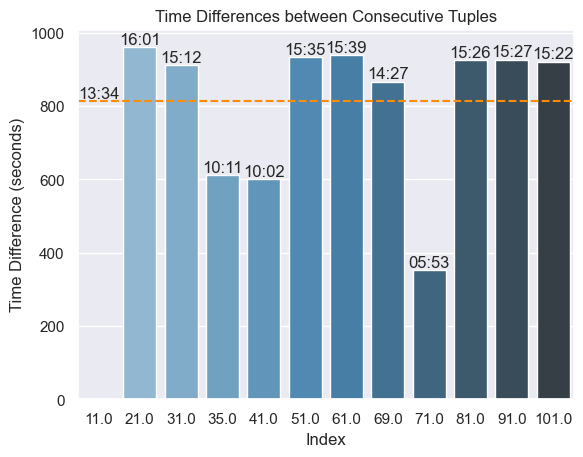

In [23]:
plot_time_diff(log_dataframe, 'epoch', 'time_diff_sec')

<font color='orange'>*Obs:* There are 3 outliers that shouldn't be there...</font>

### **Time taken by metrics**

In [39]:
log_time_regex = r'''
    \[(\d{4})-(\d{2})-(\d{2})\s(\d{2}):(\d{2}):(\d{2})\]\s
    \[valid\]\s
    (.+)
'''

log_time_regex = re.compile(log_time_regex, re.VERBOSE)

In [40]:
time_lines = parse_line_groups(log_lines, log_time_regex)

In [46]:
' '.join(time_lines[0])

'2023 05 19 17 52 23 References contain unknown word, metric scores may be inaccurate'

In [47]:
def create_log_metric_dataframe(parsed_lines, debug=False):
    # type: (list[tuple[str, str, str, str, str, str]], bool) -> pd.DataFrame
    log = dict()
    static_columns = ['index', 'year', 'month', 'day', 'hour', 'minute', 'second', 'rest']
    for column in static_columns:
        log[column] = []

    for idx, line in enumerate(parsed_lines):
        static_values_to_append = [idx, *line]
        for column, value in zip(static_columns, static_values_to_append):
            log[column].append(value)

    if debug:
        print('seen epochs: {}'.format(log))
    
    return pd.DataFrame(log)

In [52]:
log_metric_dataframe = create_log_metric_dataframe(time_lines)

In [53]:
log_metric_dataframe.head()

,index,year,month,day,hour,minute,second,rest
0,0,2023,05,19,17,52,23,"References contain unknown word, metric scores..."
1,1,2023,05,19,17,52,23,First sentence's tokens as scored:
2,2,2023,05,19,17,52,23,DefaultVocab keeps original segments for scoring
3,3,2023,05,19,17,52,23,"Hyp: El presidente Mario Abdo BenÃ­tez, en e..."
4,4,2023,05,19,17,52,23,Ref: El escÃ¡ndalo causado en TaiwÃ¡n por el...


In [54]:
log_metric_dataframe = add_time_diff(log_metric_dataframe)

In [55]:
log_metric_dataframe.tail()

,index,year,month,day,hour,minute,second,rest,datetime,time_diff
93,93,2023,05,19,20,21,58,Ref: El escÃ¡ndalo causado en TaiwÃ¡n por el...,2023-05-19 20:21:58,0 days 00:00:00
94,94,2023,05,19,20,23,24,Ep. 101 : Up. 29073 : bleu : 0.899596 : stalle...,2023-05-19 20:23:24,0 days 00:01:26
95,95,2023,05,19,20,24,57,Ep. 101 : Up. 29073 : chrf : 18.2 : stalled 3 ...,2023-05-19 20:24:57,0 days 00:01:33
96,96,2023,05,19,20,25,06,Ep. 101 : Up. 29073 : cross-entropy : 243.137 ...,2023-05-19 20:25:06,0 days 00:00:09
97,97,2023,05,19,20,26,37,Ep. 101 : Up. 29073 : translation : 0 : stalle...,2023-05-19 20:26:37,0 days 00:01:31


In [58]:
def create_metric_time_dataframe(dataframe, metrics, debug=False):
    # type: (pd.DataFrame, list[str], bool) -> pd.DataFrame
    metric_time_dataframe = {}
    for idx, row in dataframe.iterrows():
        for metric in metrics:
            if metric in row['rest']:
                metric_time_dataframe.setdefault(metric, [])
                metric_time_dataframe[metric].append(row['time_diff'])

    if debug:
        print('metric time dataframe: {}'.format(metric_time_dataframe))

    return pd.DataFrame(metric_time_dataframe)

In [59]:
time_metric_df = create_metric_time_dataframe(log_metric_dataframe, metrics)

In [61]:
time_metric_df.tail()

,bleu,chrf,cross-entropy
7,0 days 00:01:20,0 days 00:01:30,0 days 00:00:09
8,0 days 00:02:48,0 days 00:01:35,0 days 00:00:09
9,0 days 00:01:29,0 days 00:01:35,0 days 00:00:08
10,0 days 00:01:29,0 days 00:01:31,0 days 00:00:08
11,0 days 00:01:26,0 days 00:01:33,0 days 00:00:09


In [73]:
time_metric_df.describe()

,bleu,chrf,cross-entropy
count,12,12,12
mean,0 days 00:02:02.333333333,0 days 00:01:32.083333333,0 days 00:00:08.250000
std,0 days 00:01:39.680702366,0 days 00:00:07.115390915,0 days 00:00:00.452267016
min,0 days 00:01:09,0 days 00:01:21,0 days 00:00:08
25%,0 days 00:01:26,0 days 00:01:29.750000,0 days 00:00:08
50%,0 days 00:01:28.500000,0 days 00:01:31,0 days 00:00:08
75%,0 days 00:01:34,0 days 00:01:33.500000,0 days 00:00:08.250000
max,0 days 00:07:09,0 days 00:01:51,0 days 00:00:09
